## Import

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

## Discipline

In [2]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [3]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

## Uncertain Space

In [4]:
from gemseo_oad_training.unit import convert_from
from gemseo.scenarios.mdo_scenario import MDOScenario
from gemseo import configure_logger

configure_logger()


<RootLogger root (INFO)>

In [ ]:
from gemseo.algos.parameter_space import ParameterSpace
from utils import update_default_inputs

x_def={'slst':convert_from('kN',150),'n_pax':150.0,'area':180.0,'ar':9.0,'fuel_type':'kerosene','engine_type':'turbofan','design_range':5500000}
update_default_inputs(disciplines,x_def)
uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)



In [6]:
from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline


In [ ]:
training_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_MONTE_CARLO", n_samples=100)

    INFO - 17:34:11: *** Start Sampling execution ***
    INFO - 17:34:11: Sampling
    INFO - 17:34:11:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:34:11:    MDO formulation: MDF
    INFO - 17:34:11: Running the algorithm OT_MONTE_CARLO:
    INFO - 17:34:14:    100%|██████████| 100/100 [00:02<00:00, 46.11 it/sec]
    INFO - 17:34:14: *** End Sampling execution (time: 0:00:02.181003) ***


In [8]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", training_dataset)

In [9]:
r2 = surrogate_discipline.get_error_measure("R2Measure")
r2.compute_learning_measure(as_dict=True)


{'fm': array([1.]),
 'length': array([1.]),
 'mtom': array([1.]),
 'span': array([1.]),
 'tofl': array([1.]),
 'vapp': array([1.]),
 'vz': array([1.])}

In [10]:
r2.compute_cross_validation_measure(as_dict=True)


{'fm': array([0.99931487]),
 'length': array([nan]),
 'mtom': array([0.99913381]),
 'span': array([1.]),
 'tofl': array([0.99913216]),
 'vapp': array([0.99910602]),
 'vz': array([0.99941919])}

In [11]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)


{'fm': array([7.02166694e-17]),
 'length': array([0.]),
 'mtom': array([0.]),
 'span': array([0.]),
 'tofl': array([0.]),
 'vapp': array([3.17764372e-15]),
 'vz': array([4.78298717e-16])}

In [12]:
rmse.compute_cross_validation_measure(as_dict=True)


{'fm': array([0.00049315]),
 'length': array([0.]),
 'mtom': array([9.69545555]),
 'span': array([0.]),
 'tofl': array([0.26671927]),
 'vapp': array([0.0041524]),
 'vz': array([0.00267169])}

In [13]:
from matplotlib import pyplot as plt

from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics

In [14]:
statistics = EmpiricalStatistics(training_dataset)
mean = statistics.compute_mean()
mean

{'aef': array([1.00788825]),
 'cef': array([1.00629333]),
 'fm': array([1.19169286]),
 'length': array([37.]),
 'mtom': array([75072.62669421]),
 'sef': array([1.00791544]),
 'span': array([40.24922359]),
 'tofl': array([1128.2551138]),
 'vapp': array([56.76798795]),
 'vz': array([7.34141378])}

In [15]:
variance = statistics.compute_variance()
variance

{'aef': array([7.37077678e-05]),
 'cef': array([8.44338002e-05]),
 'fm': array([0.00035496]),
 'length': array([0.]),
 'mtom': array([108523.81364031]),
 'sef': array([7.1277677e-05]),
 'span': array([5.04870979e-29]),
 'tofl': array([81.97279175]),
 'vapp': array([0.01928714]),
 'vz': array([0.01228967])}

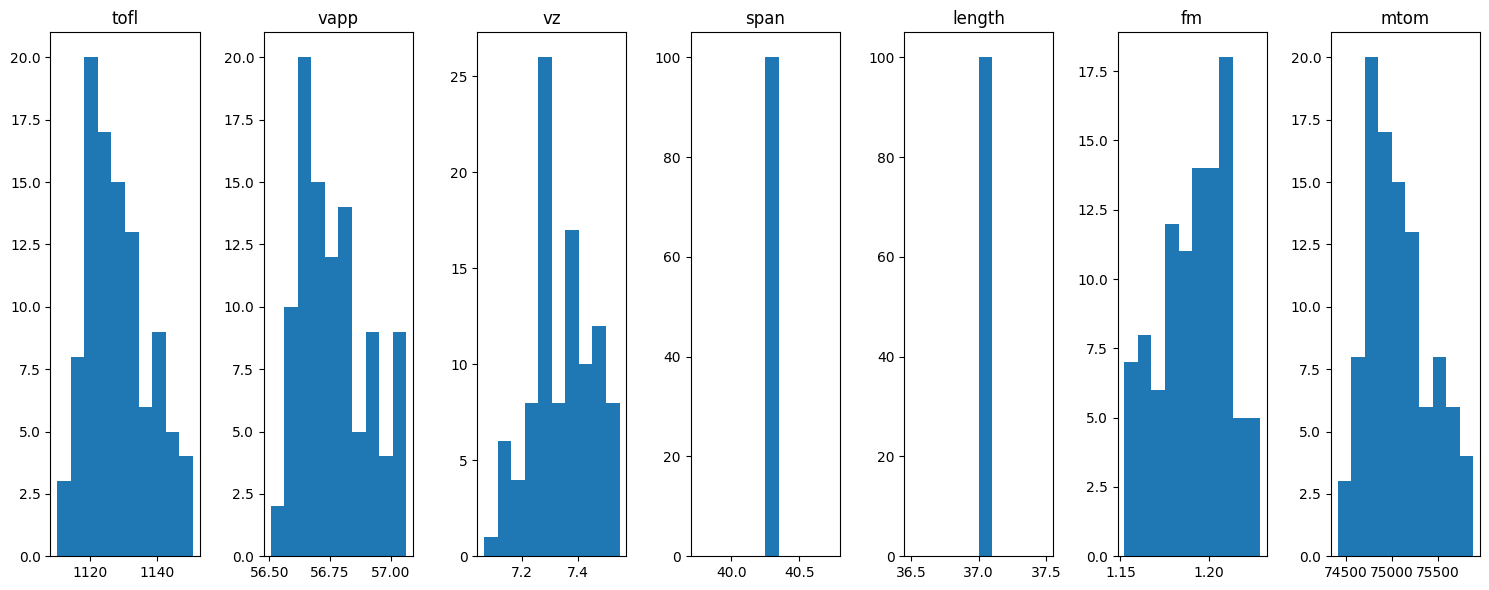

In [16]:
fig, axes = plt.subplots(1, 7,figsize=(15,6))
for ax, name in zip(axes, ["tofl", "vapp","vz","span","length","fm","mtom"]):
    ax.hist(training_dataset.get_view(variable_names=name))
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [17]:
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis


In [18]:
sobol = SobolAnalysis()
sobol.compute_samples([surrogate_discipline], uncertain_space, 1000)

 WARNING - 17:34:16: No coupling in MDA, switching chain_linearize to True.
    INFO - 17:34:16: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 17:34:16: SobolAnalysisSamplingPhase
    INFO - 17:34:16:    Disciplines: RBF_Sampling
    INFO - 17:34:16:    MDO formulation: MDF
    INFO - 17:34:16: Running the algorithm OT_SOBOL_INDICES:
    INFO - 17:34:26:    100%|██████████| 1000/1000 [00:10<00:00, 93.35 it/sec]
    INFO - 17:34:26: *** End SobolAnalysisSamplingPhase execution (time: 0:00:10.772716) ***


GROUP        inputs                       outputs                       \
VARIABLE        aef       cef       sef        fm length          mtom   
COMPONENT         0         0         0         0      0             0   
0          1.011287  1.007311  0.995436  1.186215   37.0  74633.135985   
1          0.996470  1.000397  1.005658  1.214933   37.0  74848.107787   
2          1.012159  1.025222  1.010838  1.151161   37.0  75431.486896   
3          0.999643  1.004268  1.000353  1.203779   37.0  74714.820323   
4          0.999603  1.015163  1.013053  1.182277   37.0  75322.138973   
..              ...       ...       ...       ...    ...           ...   
995        0.991786  0.998037  1.013324  1.223331   37.0  75084.571113   
996        0.996654  0.997124  1.022199  1.221399   37.0  75435.564398   
997        1.015290  1.003540  1.019531  1.189591   37.0  75520.799199   
998        0.992562  1.025659  1.001652  1.168336   37.0  74975.285334   
999        1.008459  1.007255  1.004581  1.189008   37.0  74962.041625   

GROUP                                                   
VARIABLE        span         tofl       vapp        vz  
COMPONENT          0            0          0         0  
0          40.249224  1116.203666  56.561478  7.437757  
1          40.249224  1122.079470  56.730887  7.474030  
2          40.249224  1138.116731  56.816925  7.218861  
3          40.249224  1118.434179  56.643565  7.489590  
4          40.249224  1135.096530  56.852814  7.327047  
..               ...          ...        ...       ...  
995        40.249224  1128.568980  56.855818  7.436904  
996        40.249224  1138.225254  57.004017  7.315458  
997        40.249224  1140.577518  56.958809  7.174520  
998        40.249224  1125.563907  56.663691  7.464143  
999        40.249224  1125.201171  56.713103  7.366945  

[1000 rows x 10 columns]

In [25]:
sobol.compute_indices(output_names=["tofl", "vapp","vz","fm","mtom"])

SobolAnalysis.SensitivityIndices(first={'tofl': [{'aef': array([0.07412153]), 'cef': array([0.11890774]), 'sef': array([1.02249956])}], 'vapp': [{'aef': array([0.01052112]), 'cef': array([0.00790668]), 'sef': array([1.19757735])}], 'vz': [{'aef': array([0.37608053]), 'cef': array([0.07756967]), 'sef': array([0.60368704])}], 'fm': [{'aef': array([0.16677755]), 'cef': array([0.82945806]), 'sef': array([0.0047788])}], 'mtom': [{'aef': array([0.07351624]), 'cef': array([0.11819174]), 'sef': array([1.02221657])}]}, second={'tofl': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.07253276]]), 'sef': array([[-0.09317706]])}, 'cef': {'aef': array([[-0.07253276]]), 'cef': array([[0.]]), 'sef': array([[0.00514078]])}, 'sef': {'aef': array([[-0.09317706]]), 'cef': array([[0.00514078]]), 'sef': array([[0.]])}}], 'vapp': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.01974572]]), 'sef': array([[-0.01636578]])}, 'cef': {'aef': array([[-0.01974572]]), 'cef': array([[0.]]), 'sef': array([[-0.01578

In [26]:
import pprint

In [27]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'fm': [{'aef': array([0.16677755]),
         'cef': array([0.82945806]),
         'sef': array([0.0047788])}],
 'mtom': [{'aef': array([0.07351624]),
           'cef': array([0.11819174]),
           'sef': array([1.02221657])}],
 'tofl': [{'aef': array([0.07412153]),
           'cef': array([0.11890774]),
           'sef': array([1.02249956])}],
 'vapp': [{'aef': array([0.01052112]),
           'cef': array([0.00790668]),
           'sef': array([1.19757735])}],
 'vz': [{'aef': array([0.37608053]),
         'cef': array([0.07756967]),
         'sef': array([0.60368704])}]}
{'fm': [{'aef': array([0.18523248]),
         'cef': array([0.8070254]),
         'sef': array([-0.0005156])}],
 'mtom': [{'aef': array([0.03453842]),
           'cef': array([0.07309855]),
           'sef': array([0.86722331])}],
 'tofl': [{'aef': array([0.03456154]),
           'cef': array([0.07279625]),
           'sef': array([0.86691687])}],
 'vapp': [{'aef': array([-0.00409306]),
           'cef': array([-0.

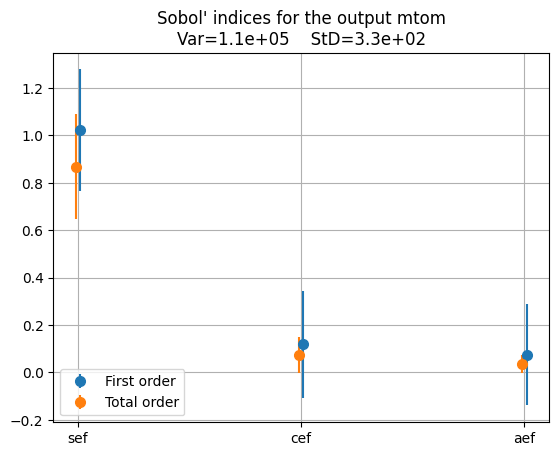

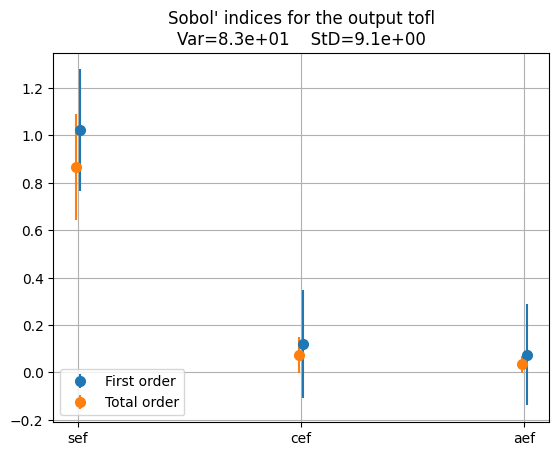

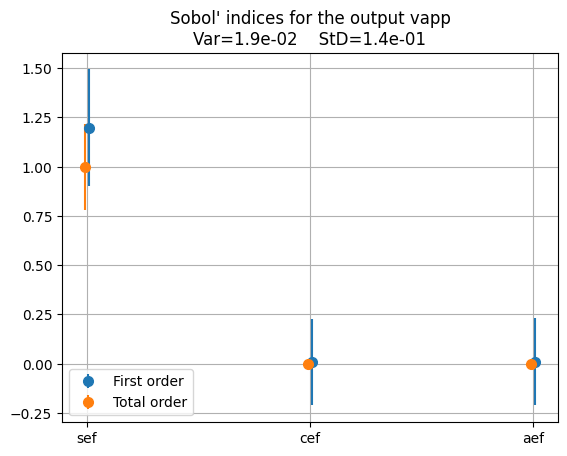

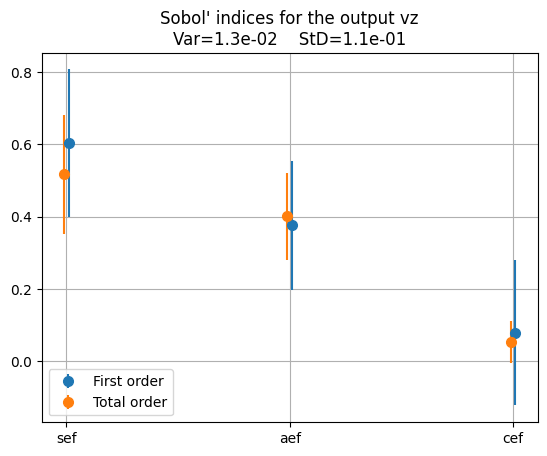

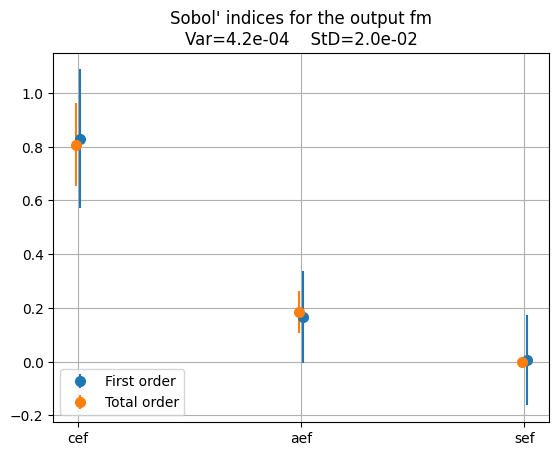

In [30]:
plt.show(sobol.plot("mtom", save=False, show=True))
plt.show(sobol.plot("tofl", save=False, show=True))
plt.show(sobol.plot("vapp", save=False, show=True))
plt.show(sobol.plot("vz", save=False, show=True))
plt.show(sobol.plot("fm", save=False, show=True))



